In [1]:
import random as rd
import numpy as np
from itertools import product
from scipy import optimize
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]   

In [2]:
#Correlation matrix of 100 stocks based on their sector structure

def tanh(x):
    for (k,i,j) in product(range(0,61), range(0,100), range(0,100)):
        x[k][i][j] = np.tanh(x[k][i][j])


def daily_correlation(sigma):
    daily_corr = np.zeros((61, 100, 100))
    for (i, j) in product (range(0,100), range(0,100)):
        if (i>j):
            daily_corr[0][i][j] = np.random.normal(M2_S[i/10][j/10], sigma, 1)
            daily_corr[0][j][i] = daily_corr[0][i][j]
        else:
            if (i==j):
                daily_corr[0][i][j] = 1.0
        for k in range(1, 61):
            if (i>j):
                daily_corr[k][i][j] = np.random.normal(daily_corr[k-1][i][j], sigma, 1)
                daily_corr[k][j][i] = daily_corr[k][i][j]
            else:
                if (i==j):
                    daily_corr[k][i][j] = 1.0  
    tanh(daily_corr)
    return daily_corr

daily_corr = daily_correlation(0.3)




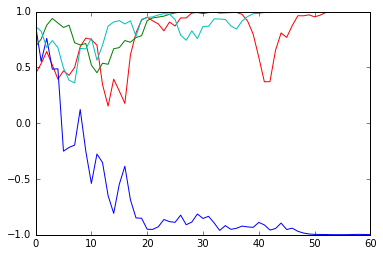

In [3]:
 #Plots showing evolution of the correlations between some stocks
def plots(daily_corr):       
    a,b,c,d = [],[],[],[]
    for i in range (0,61):
        a.append(daily_corr[i][9][94])
        b.append(daily_corr[i][97][95])
        c.append(daily_corr[i][10][11])
        d.append(daily_corr[i][10][12])

    plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
    plt.show()

    
plots(daily_corr)

In [4]:
#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples, daily_corr):
    mu = np.zeros(100)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns

In [5]:
#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples, daily_corr):
    r0, r1 = return_generator(N_samples, daily_corr)
    model1 = []
    model2 = np.zeros((N_samples, 100, 100))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,10), range(0,10)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for (i,j) in product(range(0,100), range(0,100)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    


In [6]:
#Weights for standard minimum variance Markowitz portfolio
bnds = []
for i in range(0,100):
    bnds.append((0, None))
bnds = tuple(bnds)
cons_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
def portfolio_variance(x, matrix):
    p_var = np.dot(np.dot(x, matrix), x)
    return p_var
def grad_portfolio_var(x, matrix):
    grad = []
    for i in range(0,100):
        s = np.dot(matrix[i], x)+matrix[i][i]*x[i]
        grad.append(s)
    return grad
def weights(matrix, number_of_weights):
    x0 = (1./number_of_weights)*np.ones(number_of_weights)
    res = optimize.minimize(portfolio_variance, x0, args=(matrix), method = 'SLSQP',
                            jac = grad_portfolio_var, bounds=bnds, constraints=cons_sum,
                            options={'maxiter': 100})
    return res.x

In [7]:
#Error function for sample/out_of_sample as variance of optimal portfolio returns
#range_of_sample - range on which we estimate optimal weights
#out_of_sample range is set to be 200
m2 = np.identity(100)
def error(x, sample_or_not, range_of_sample):
    if (sample_or_not=='sample'):
        boundary0 = 0
        boundary1 = range_of_sample
    if (sample_or_not=='out_of_sample'):
        boundary0 = N_samples - range_of_sample
        boundary1 = N_samples
    portfolio_returns = []
    for k in range (boundary0, boundary1):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 100)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)

In [8]:
#Optimizing model weights with positivity constraints 
#Function depending on the range_of_sample
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
def optimal_model_weights(a):
    x0 = [0.5, 0.3]
    start_time = datetime.datetime.now()
    res = optimize.minimize(error, x0, args=('sample', a), method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 100})
    return datetime.datetime.now() - start_time, res.x, res.fun


In [9]:
times = []
results = []
sample_error = []
out_of_sample_error = []
range_of_sample = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500, 5000]
N_samples = 5200
daily_corr = daily_correlation(0.9)
m0, m1, r1 = empiric_models(N_samples, daily_corr)
results, sample_error, times, out_of_sample_error = [], [], [], []
for i in range_of_sample:
    time, result, err = optimal_model_weights(i)
    sample_error.append(err)
    results.append([result[0], result[1], 1-result[0]-result[1]])
    times.append(time)
    print time, result, err
    e = error(result, 'out_of_sample', 200)
    print e

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\Mikhail\Anaconda2\lib\site-packages\scipy\optimize\slsqp.py:337: RuntimeWarning: invalid value encountered in greater
  bnderr = where(bnds[:, 0] > bnds[:, 1])[0]


0:02:42.933000 [ 0.75048289  0.2471991 ] 0.0641006777236
0.0663416718708
0:05:50.147000 [ 0.74388541  0.25609283] 0.0662468840241
0.0663045355276
0:06:06.905000 [ 0.73443079  0.22068411] 0.0659684530942
0.0661855423221
0:08:08.482000 [ 0.541452   0.2787931] 0.0670312901051
0.066045313475
0:10:47.781000 [ 0.72566589  0.18715568] 0.0673103865402
0.0659786203009
0:13:39.060000 [ 0.72715012  0.20120121] 0.0655923036709
0.0661497773222
0:14:22.690000 [ 0.73118287  0.20883976] 0.0664870866011
0.0662063045262
0:18:37.883000 [ 0.73117115  0.20951522] 0.0651336085467
0.0662095375948
0:15:04.827000 [ 0.50319617  0.34543659] 0.0642518212276
0.0664868744294
0:24:08.919000 [ 0.73332343  0.22970094] 0.0633685496978
0.0660400948862
0:38:02.814000 [ 0.73858536  0.24351255] 0.0638823269874
0.0661294706735
0:49:52.580000 [ 0.74740184  0.24364414] 0.0631062177628
0.066296031334
1:02:01.396000 [ 0.74852478  0.24426499] 0.0621150378573
0.0663120049653
1:56:56.017000 [ 0.72925471  0.2218455 ] 0.064813539744

 500 0.725665889298


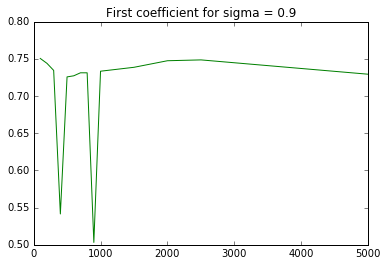

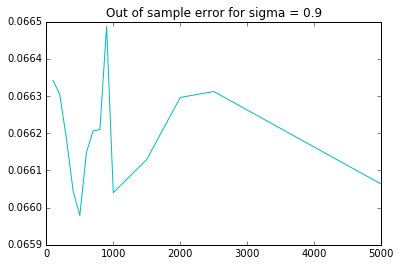

In [19]:
first_coef = []
for i in range(0,14):
    first_coef.append(results[i][0])
out_of_sample_error = [0.0663416718708, 0.0663045355276, 0.0661855423221, 0.066045313475, 0.0659786203009, 0.0661497773222, 
                      0.0662063045262, 0.0662095375948, 0.0664868744294, 0.0660400948862, 0.0661294706735, 0.066296031334, 
                      0.0663120049653, 0.066063321933]
index = np.argmin(out_of_sample_error)
print range_of_sample[index], first_coef[index]
plt.plot(range_of_sample, first_coef, 'g')
plt.title('First coefficient for sigma = 0.9')
plt.show()
plt.plot(range_of_sample, out_of_sample_error, 'c')
plt.title('Out of sample error for sigma = 0.9')
plt.show()